<a href="https://colab.research.google.com/github/ritikraj660/Speaker-recognition/blob/master/Liveliness_detection_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [20]:

link = 'https://drive.google.com/file/d/12fAst4usbQKCMaR6Io8OPNwna2Ye8S-o/view?usp=sharing'
#fluff, id = link.split('=')
id = '12fAst4usbQKCMaR6Io8OPNwna2Ye8S-o'
print (id) 

12fAst4usbQKCMaR6Io8OPNwna2Ye8S-o


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('liveliness.zip')  

In [22]:
%%time
!pip install patool
import patoolib
patoolib.extract_archive("liveliness.zip")

     |████████████████████████████████| 81kB 5.0MB/s 
patool: Extracting liveliness.zip ...
patool: running /usr/bin/7z x -o./Unpack_ybkndyr4 -- liveliness.zip
patool: ... liveliness.zip extracted to `liveliness'.
CPU times: user 29.2 ms, sys: 26.7 ms, total: 55.9 ms
Wall time: 6.34 s


In [161]:
!pip install spafe
from spafe.features.mfcc import mfcc

     |████████████████████████████████| 81kB 5.4MB/s 


In [0]:
!pip install soundfile

In [0]:
import librosa
import soundfile
import tqdm
from scipy.io import wavfile
import glob
import os,pickle
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import soundfile as sf
import scipy
from pathlib import Path
import tensorflow.python.keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.optimizers import SGD

In [0]:
from spafe.features.gfcc import gfcc

def mfcc_(sig,fs):
    mfccs  = mfcc(sig, fs=fs, num_ceps=20, pre_emph=1, pre_emph_coeff=0.95, 
              win_len=0.025, win_hop=0.0025, win_type='hamming', nfilts=26, 
              nfft=512, low_freq=14500, high_freq=15500, scale='constant', 
              dct_type=2, use_energy=True, lifter=22)
    #print(fs)
    return mfccs

In [0]:
def norm_(x,mean = False):
    if mean == True:
        return (x - np.mean(x)) / (np.max(x) - np.min(x)) #normalization                             
    else:
        return (x-np.mean(x)/np.std(x)) #standardization

def zero_handling(x):
    """
    handle the issue with zero values if they are exposed to become an argument
    for any log function.

    Returns:
        vector with zeros substituted with epsilon values.
    """
    return np.where(x == float(0), np.finfo(float).eps, x)

In [0]:
def audioLengthInSecond(sr,m,t_s):#t_s will gives time in second[1 for 1sec, 2 for 2sec]
    t = round(sr/512) # Number of frames in one second
    totalFrame = round(t*t_s) # Number of frames in one second * time(second)
    t1 = round(m.shape[0]/totalFrame) # total_audio_time/ t_s
    #print(time_in_sec)
    #print(" Actual audio length in second :",t1,"\n","Number of frames in one second :",t)
    j=0
    #print(totalFrame)
    total = totalFrame*m.shape[1]
    #print(m.shape)
    result = np.zeros([1,total])
    #print(total)
    #print(result.shape)
    for i in range(t1):
            temp = m[j:j+totalFrame,:].reshape(1,-1)
            diff = total-temp.shape[1]
            if round(total*0.3)>diff: # if more 30% padding need done then we will not add that audio file
                #print(diff)
                if diff!=0:
                    temp = np.concatenate((temp[0,:],temp[0,diff:diff+diff])).reshape(1,-1)
                #print("temp",temp.shape)
                result = np.concatenate((result,temp))
                j += totalFrame
            else:
                pass
    return result[1:,:]
#t_s=0.5
#r = audioLengthInSecond(sr,contrast,t_s)
#print(r.shape)

In [0]:
def label(user,total): # its creating lable for splited audio data
    k_train = []
    for i in range(total):
        k_train.append(user)
    y_train=np.array(k_train).T

    return y_train

In [0]:
from pathlib import Path
def s2c():
    x,y=[],[]
    t_s = 1
    t = round(48000/512)
    totalFrame = round(t*t_s)
    total = totalFrame*20   
    data = np.empty([1,total])
    data_label = np.asarray([])
    count =0  # E:\dataset\LibriSpeech\dev-clean
    for file in Path('liveliness').glob('*.wav'):
        file_name=os.path.basename(file)
        user = file_name[0]
        #print(f)
      
        with soundfile.SoundFile(file) as sound_file:
                signal = sound_file.read(dtype="float32")
                sr=sound_file.samplerate
        signal = norm_(signal,mean = False)
        signal = zero_handling(signal)
 
        feature = mfcc_(signal,sr)
              #print(feature.shape[0])
        re_data = audioLengthInSecond(sr,feature,t_s) # return (3,400)
        #print("shape of feature return ",re_data.shape)
        data=np.concatenate((data,re_data),axis=0)
        #print("Updated data length",data.shape)
        re_label = label(user,re_data.shape[0])
        data_label = np.concatenate((data_label,re_label),axis=0)
    return data[1:,:],data_label

In [0]:
def load_data1():
    #x,y=[],[]   #C:\Users\RITIK_RAJ\Music\liveliness\*.wav
    #for file in glob.glob("C:\\Users\\RITIK_RAJ\\Music\\liveliness//*\\*.wav"):   
    print("Entered into pre-processing step")
    data = np.empty([1,329])  #658, #329
    data_label = np.asarray([])
    for file in Path('liveliness').glob('*.wav'):
        file_name=os.path.basename(file)
        #print("user_name", file_name[0])
        user = file_name[0]
        with soundfile.SoundFile(file) as sound_file:
            X = sound_file.read(dtype="float32")
            sample_rate=sound_file.samplerate
        #print("Length of Audio = ",X.shape," Sampling Rate = ",sample_rate)
        X = norm_(X,mean = False)
        X = zero_handling(X)
        psi = scipy.signal.butter(4, [14500, 15500], btype='bandpass', output='sos', fs=sample_rate)
        # filter audio
        y_filtered = scipy.signal.sosfilt(psi, X)
        #print("Butter_worth_filter",y_filtered.shape)
        S = np.abs(librosa.stft(y_filtered, hop_length= 256, win_length =1024 ))
        #print("STFT shape = ",S.shape)
        contrast = librosa.feature.spectral_contrast(S=S, sr=sample_rate).T
        #print("Feature extraction ",contrast.shape)
        r = audioLengthInSecond(sample_rate,contrast,t_s=0.5)
        #print(r.shape)
        data=np.concatenate((data,r),axis=0)
        re_label = label(user,r.shape[0])
        data_label = np.concatenate((data_label,re_label),axis=0)
    print("Exiting Pre-processing step")    
    return data[1:,:],data_label

In [0]:
#x,y = load_data()
#print(x.shape,y.shape)

In [0]:
def data_split():
  #X  = x.reshape(x.shape[0],x.shape[1],x.shape[2],1)
  x,y = s2c()#load_data()
  u = np.unique(y)
  num_cla = len(u)
  #print(u)
  d = dict()
  for enu,key in enumerate(u,0):
      d[key]=enu
  #print(d)
  for i in range(len(y)):
      y[i] = d[y[i]]  
  print(x.shape,y.shape)
  print("Shape of Input data ",x.shape)
  import keras

  y_binary = keras.utils.to_categorical(y, num_classes = num_cla)
  #y_binary = np.asarray(list(map(int,y)))
  #print(y_binary)

  x_train, x_test, y_train, y_test = train_test_split(x,y_binary ,test_size=0.20, shuffle= True)

  print("Training shape: {0}, Training label shape : {1}".format(x_train.shape,y_train.shape))
  print("Training shape: {0}, Training label shape : {1}".format(x_test.shape,y_test.shape))
  return  x_train, x_test, y_train, y_test

In [0]:
import keras
from matplotlib import pyplot as plt
def accuracy_plot(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

def loss_plot(history):
    plt.figure(figsize=(15,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.grid()
    plt.show()

In [0]:
from tensorflow.keras.optimizers import SGD
from tensorflow.python.keras.callbacks import ModelCheckpoint
def model_(x,outputsize):
  model = Sequential()
  model.add(Dense(64, input_shape=(x.shape[1],), activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(outputsize, activation='softmax'))
  #print(model.summary())
  opt = SGD(lr=0.001, momentum=0.9)                        #optimizer=keras.optimizers.Adam()
  #opt =Adam(learning_rate=0.001)
  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
  #tensorflow.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True,
  #                         rankdir='TB', expand_nested=False, dpi=96)
  print(model.summary())
  return model
  

In [0]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas.util.testing as tm
import seaborn as sns
import numpy as np
def conf(y_test,yhat):
  y_test = np.argmax(y_test, axis=1)
  total_user = ['Live','Replay']
  #total_user = [0,1]
  conf_mat = confusion_matrix(y_test, yhat)
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_mat, cmap="YlGnBu",annot=True, fmt='d',
              xticklabels=total_user, yticklabels=total_user)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

In [0]:
def training(model,x_train, x_test, y_train, y_test,epoch = 300,batch_sizes = 16):
  # Saving the model that performed the best on the validation set
  checkpoint = ModelCheckpoint(filepath='Model.v_2.hdf5', save_best_only=True, verbose=0)

  #validation_split=0.2

  #history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
  #                    validation_data=(x_test, y_test), verbose=0, callbacks=[checkpoint])
  history = model.fit(x_train, y_train, batch_size = batch_sizes, epochs=epoch, 
                      validation_split=0.2, verbose=0, callbacks=[checkpoint])
  #Loading the model that performed the best on the validation set
  model.load_weights('Model.v_2.hdf5')

  # Testing the model on the Test data
  (loss, accuracy) = model.evaluate(x_test, y_test, batch_size=8, verbose=1)

  yhat = np.argmax(model.predict(x_test), axis=-1)
  conf(y_test,yhat)
  accuracy_plot(history)
  loss_plot(history)
  print('Accuracy on test data: {:.2f}%'.format(accuracy * 100))
  print('Loss on test data: {:.2f}%'.format(loss*100))
  return [accuracy*100,loss*100]

In [302]:
%%time
class speaker:

  def __init__(self,epoch,batch_sizes):
    self.epoch = epoch
    self.batch_sizes = batch_sizes
    self.run()


  def run(self):
    x_train, x_test, y_train, y_test = data_split()
    print("Entering making model")
    model = model_(x_train,2)
    print("Enteres training phase")
    #l.append(training(model, x_train, x_test, y_train, y_test,self.epoch, self.batch_sizes))
    training(model, x_train, x_test, y_train, y_test,self.epoch, self.batch_sizes)
    #print("Accuracy of model {}, Loss of model {}".format(l[0],l[1]))


CPU times: user 35 µs, sys: 3 µs, total: 38 µs
Wall time: 42.7 µs


(5957, 1880) (5957,)
Shape of Input data  (5957, 1880)
Training shape: (4765, 1880), Training label shape : (4765, 2)
Training shape: (1192, 1880), Training label shape : (1192, 2)
Entering making model
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_104 (Dense)            (None, 64)                120384    
_________________________________________________________________
dropout_54 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_105 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_55 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_106 (Dense)            (None, 64)                4160      
________________________________________________

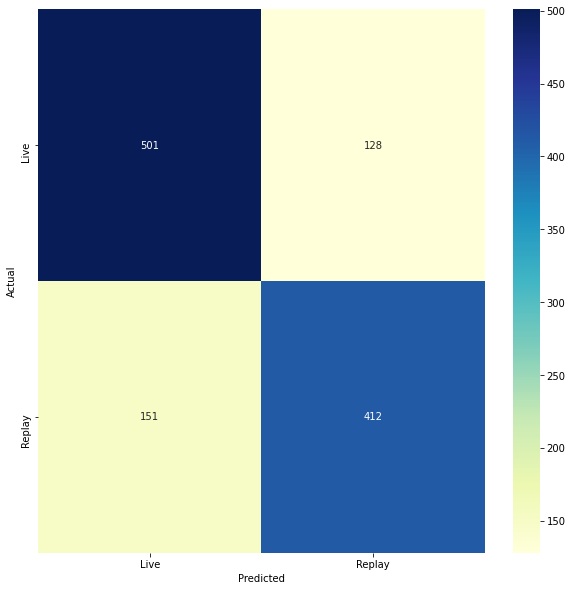

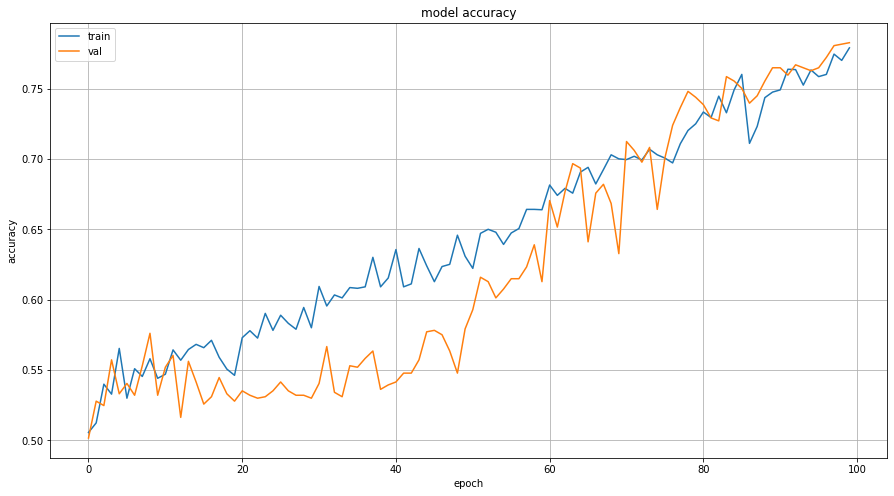

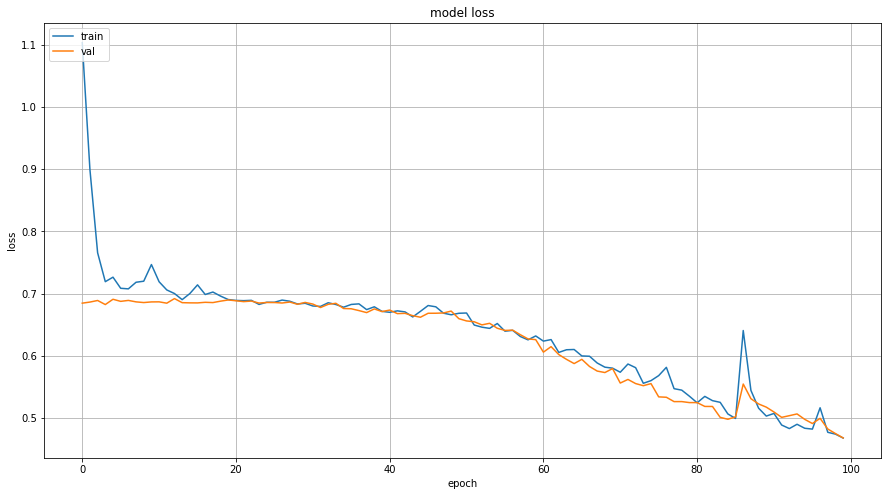

Accuracy on test data: 76.59%
Loss on test data: 49.59%
CPU times: user 1min 21s, sys: 7.1 s, total: 1min 28s
Wall time: 1min 3s


In [304]:
%%time
speaker(epoch = 100, batch_sizes = 16)